# 🧠 Q-Learning Test on QQQ ETF
This notebook downloads QQQ ETF data and applies a simple Q-learning agent for a test run using binary trend state.


In [43]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set QQQ CSV path (one level above this notebook)
qqq_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset', 'QQQ.csv'))
os.makedirs(os.path.dirname(qqq_path), exist_ok=True)

print("Reading manually exported Yahoo CSV...")

# Read Yahoo-exported CSV (skip first two header rows)
df = pd.read_csv(qqq_path, skiprows=2)

# Rename columns to standard format
df.columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

# Parse date and set as index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df.set_index('Date', inplace=True)

# Keep relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Add scaled volume feature: today's volume relative to 10-day average
df['volume_scaled'] = df['Volume'] / df['Volume'].rolling(window=10).mean()
df['volume_scaled'] = df['volume_scaled'].fillna(1)

print("Cleaned data preview:")
df.head()


Reading manually exported Yahoo CSV...
Cleaned data preview:


,Open,High,Low,Close,Volume,volume_scaled
Date,,,,,,
2018-01-02,156.559998,158.529999,156.169998,158.490005,32573300,1.0
2018-01-03,158.639999,160.169998,158.610001,160.029999,29383600,1.0
2018-01-04,160.580002,160.789993,160.080002,160.309998,24776100,1.0
2018-01-05,161.070007,162.029999,160.770004,161.919998,26992300,1.0
2018-01-08,161.919998,162.630005,161.860001,162.550003,23159100,1.0


## 🧮 Define Features and Trend Labels
We'll use a very simple setup:  
- `prev_trend = 1` if price went up yesterday  
- `label = 1` if price goes up tomorrow  
Perfect for simple Q-learning state/action mapping.


In [44]:
# Compute daily return and label: 1 if price will rise tomorrow
df['return'] = df['Close'].pct_change()
df['label'] = (df['return'].shift(-1) > 0).astype(int)

# Feature 1: Previous trend — 1 if yesterday's return > 0, else 0
df['prev_trend'] = (df['return'] > 0).astype(int).shift(1)

# Feature 2: Scaled volume — already added in previous block, shift to avoid lookahead
df['volume_scaled_shifted'] = df['volume_scaled'].shift(1)

# Feature 3: Momentum — 3-day rolling average return, shifted to avoid future info
df['momentum'] = df['return'].rolling(window=3).mean().shift(1)

# Drop rows with NaN (caused by pct_change, rolling, shifting)
df = df.dropna()

# Preview final features to use in state
df[['label', 'prev_trend', 'volume_scaled_shifted', 'momentum']].tail()


,label,prev_trend,volume_scaled_shifted,momentum
Date,,,,
2023-12-22,1,1.0,0.944570,0.000628
2023-12-26,1,1.0,0.729472,-0.000576
2023-12-27,0,1.0,0.503130,0.006418
2023-12-28,0,1.0,0.719662,0.003042
2023-12-29,0,0.0,0.649735,0.002382


## 🤖 Q-Learning Agent
Simple agent that learns via a Q-table with 2 states and 2 actions.


In [45]:
class QLearningAgent:
    def __init__(self, state_size, action_size, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995):
        self.q_table = np.zeros((state_size, action_size))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.action_size = action_size

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state, action]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.alpha * (target - predict)

    def decay(self):
        self.epsilon *= self.epsilon_decay


## 🏋️ State Encoder

In [46]:
def encode_state(row):
    """
    Convert continuous features into discrete state buckets.
    Input: row from DataFrame with columns: prev_trend, volume_scaled_shifted, momentum
    Output: tuple (trend_bin, volume_bin, momentum_bin)
    """

    # Trend is already 0 or 1
    trend_bin = int(row['prev_trend'])

    # Discretize volume_scaled: 0 = low, 1 = normal, 2 = high
    if row['volume_scaled_shifted'] < 0.8:
        volume_bin = 0
    elif row['volume_scaled_shifted'] > 1.2:
        volume_bin = 2
    else:
        volume_bin = 1

    # Discretize momentum: 0 = downtrend, 1 = neutral, 2 = uptrend
    if row['momentum'] < -0.001:
        momentum_bin = 0
    elif row['momentum'] > 0.001:
        momentum_bin = 2
    else:
        momentum_bin = 1

    return (trend_bin, volume_bin, momentum_bin)


## Train

In [ ]:
class QLearningAgent:
    def __init__(self, action_size, alpha=0.1, gamma=0.9, epsilon=1.0, epsilon_decay=0.995):
        self.q_table = {}  # Q[state_tuple] = [value_for_action_0, value_for_action_1]
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.action_size = action_size

    def get_q_values(self, state):
        if state not in self.q_table:
            self.q_table[state] = [0.0] * self.action_size
        return self.q_table[state]

    def act(self, state):
        q_values = self.get_q_values(state)
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        return int(np.argmax(q_values))

    def learn(self, state, action, reward, next_state):
        current_q = self.get_q_values(state)[action]
        max_future_q = max(self.get_q_values(next_state))
        target = reward + self.gamma * max_future_q
        self.q_table[state][action] += self.alpha * (target - current_q)

    def decay(self):
        self.epsilon *= self.epsilon_decay

# Setup
initial_cash = 100000  # Initial balance in NTD
unit_size = 1          # Buy/sell 1 share per action
action_size = 2        # 0 = Hold/Sell, 1 = Buy

agent = QLearningAgent(action_size=action_size)
rewards_history = []
portfolio_values = []

for epoch in range(300):
    total_reward = 0
    cash = initial_cash
    shares = 0

    for i in range(len(df) - 1):
        today_price = df.iloc[i]['Close']
        tomorrow_price = df.iloc[i + 1]['Close']

        state = encode_state(df.iloc[i])
        next_state = encode_state(df.iloc[i + 1])
        action = agent.act(state)

        # Simulate trade
        if action == 1 and cash >= today_price * unit_size:
            shares += unit_size
            cash -= today_price * unit_size
        elif action == 0 and shares >= unit_size:
            shares -= unit_size
            cash += today_price * unit_size
        # else: hold

        # Compute portfolio value today and tomorrow
        value_today = cash + shares * today_price
        value_tomorrow = cash + shares * tomorrow_price

        reward = value_tomorrow - value_today
        total_reward += reward

        # Learn from this step
        agent.learn(state, action, reward, next_state)

    agent.decay()
    rewards_history.append(total_reward)
    portfolio_values.append(cash + shares * df.iloc[-1]['Close'])

    print(f"Epoch {epoch+1:2d}: reward = {total_reward:8.2f}, final portfolio = {portfolio_values[-1]:.2f}, epsilon = {agent.epsilon:.4f}")


Epoch  1: reward =  7135.21, final portfolio = 107135.21, epsilon = 0.9950
Epoch  2: reward =  6943.73, final portfolio = 106943.73, epsilon = 0.9900
Epoch  3: reward =  1280.38, final portfolio = 101280.38, epsilon = 0.9851
Epoch  4: reward =  9695.18, final portfolio = 109695.18, epsilon = 0.9801
Epoch  5: reward =   196.01, final portfolio = 100196.01, epsilon = 0.9752
Epoch  6: reward =  2677.90, final portfolio = 102677.90, epsilon = 0.9704
Epoch  7: reward =  1419.47, final portfolio = 101419.47, epsilon = 0.9655
Epoch  8: reward =  8322.10, final portfolio = 108322.10, epsilon = 0.9607
Epoch  9: reward =  4360.88, final portfolio = 104360.88, epsilon = 0.9559
Epoch 10: reward =  8143.75, final portfolio = 108143.75, epsilon = 0.9511
Epoch 11: reward = 19245.13, final portfolio = 119245.13, epsilon = 0.9464
Epoch 12: reward =  6126.66, final portfolio = 106126.66, epsilon = 0.9416
Epoch 13: reward =  4704.28, final portfolio = 104704.28, epsilon = 0.9369
Epoch 14: reward =  4061.

## last

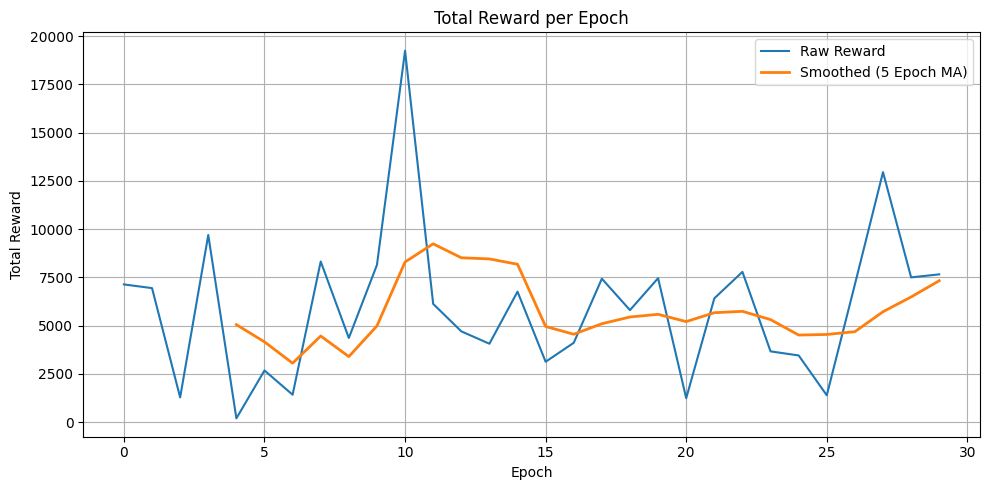

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards_history, label='Raw Reward')
plt.plot(pd.Series(rewards_history).rolling(window=5).mean(), label='Smoothed (5 Epoch MA)', linewidth=2)

plt.title("Total Reward per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


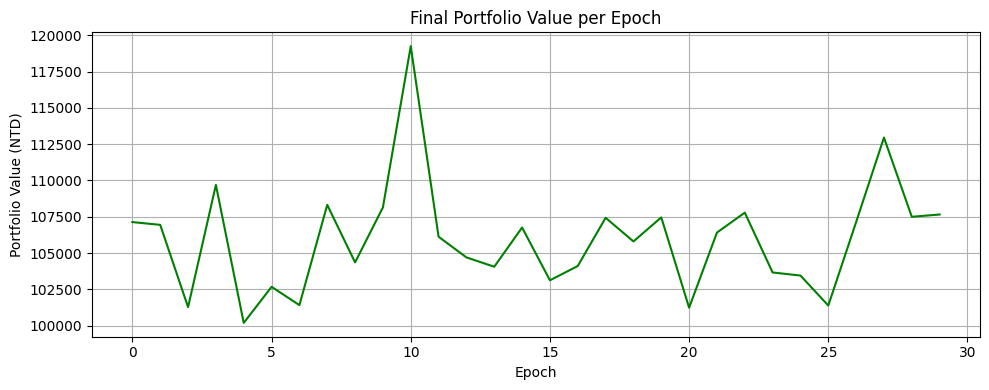

In [49]:
plt.figure(figsize=(10, 4))
plt.plot(portfolio_values, color='green')
plt.title("Final Portfolio Value per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Portfolio Value (NTD)")
plt.grid(True)
plt.tight_layout()
plt.show()
